In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [2]:
df_train = pd.read_parquet('output/train_emb.parquet')
df_test = pd.read_parquet('output/test_emb.parquet')
df_train.sample(5)

,text,label,emb_large
13973,There's the danger with the critic/philosopher...,1,"[0.007826757617294788, 0.03163137659430504, -0..."
13979,"More like psychological analysis of movies, bu...",1,"[-0.02786346897482872, 0.04245997965335846, -0..."
7362,There was a reasonably good looking girl starr...,0,"[-0.013289046473801136, 0.003490287810564041, ..."
18334,"This movie is great.<br /><br />Now, I do tend...",1,"[0.02210204489529133, 0.007192662917077541, -0..."
22291,"Once a year ""comes"" a movie like that and make...",1,"[-0.030464908108115196, 0.034395866096019745, ..."


In [3]:
feature_sizes = [50, 75, 100, 200, 300, 400, 500, 750, 1000, 1300, 1600]
emb_col = "emb_large"
target = "label"
results = []

In [4]:
for feature_size in feature_sizes:
    print(f"Evaluating feature size: {feature_size}")
    matrix_train = np.array([x for x in df_train[emb_col]])
    matrix_test = np.array([x for x in df_test[emb_col]])
    y_train = df_train[target]
    y_test = df_test[target]

    # first try simple truncation
    clf = LogisticRegression()
    clf.fit(matrix_train[:, :feature_size], y_train)
    y_pred = clf.predict(matrix_test[:, :feature_size])
    results.append(["Truncation", feature_size, sum(y_pred == y_test) / len(y_test)])

    # then try PCA
    pca = PCA(n_components=feature_size)
    matrix_reduced_train = pca.fit_transform(matrix_train)
    matrix_reduced_test = pca.transform(matrix_test)
    clf = LogisticRegression()
    clf.fit(matrix_reduced_train, y_train)
    y_pred = clf.predict(matrix_reduced_test)
    results.append(["PCA", feature_size, sum(y_pred == y_test) / len(y_test)])


Evaluating feature size: 50
Evaluating feature size: 75
Evaluating feature size: 100
Evaluating feature size: 200
Evaluating feature size: 300
Evaluating feature size: 400
Evaluating feature size: 500
Evaluating feature size: 750
Evaluating feature size: 1000
Evaluating feature size: 1300
Evaluating feature size: 1600


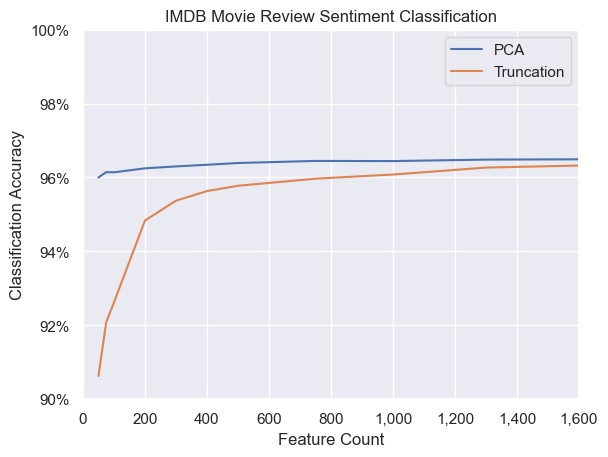

In [5]:
graph_df = pd.DataFrame({
    "method": [method for method, _, _ in results],
    "feature_size": [feature_size for _, feature_size, _ in results],
    "accuracy": [accuracy for _, _, accuracy in results]
})
graph_df_pca = graph_df[graph_df["method"] == "PCA"]
graph_df_truncation = graph_df[graph_df["method"] == "Truncation"]

sns.set_theme()
sns.lineplot(data=graph_df_pca, x="feature_size", y="accuracy", label="PCA")
sns.lineplot(data=graph_df_truncation, x="feature_size", y="accuracy", label="Truncation")
plt.xlabel("Feature Count")
plt.ylabel("Classification Accuracy")
plt.title("IMDB Movie Review Sentiment Classification")
plt.ylim(0.9, 1.0)
plt.xlim(0, 1600)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1, decimals=0))
plt.show()

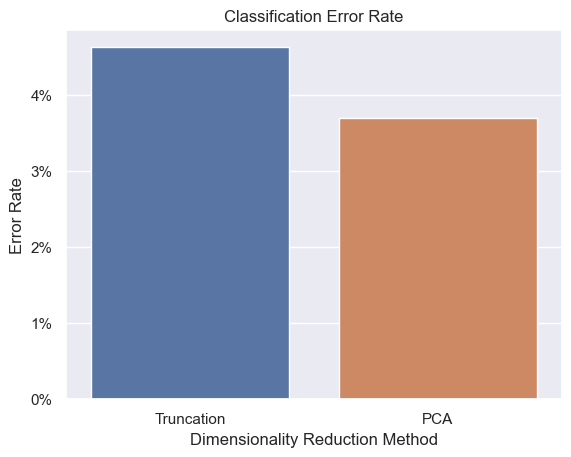

In [17]:
graph_df_error_300 = graph_df[graph_df["feature_size"] == 300].copy()
graph_df_error_300["error"] = 1 - graph_df_error_300["accuracy"]
sns.set_theme()
ax = sns.barplot(data=graph_df_error_300, x="method", y="error", hue="method")
plt.xlabel("Dimensionality Reduction Method")
plt.ylabel("Error Rate")
plt.title("Classification Error Rate")
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1, decimals=0))
plt.show()